In [1]:
from time import time
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import SimpleITK as sitk
import six
from radiomics import featureextractor 
from radiomics import imageoperations
import numpy as np
from numpy import linalg

In [2]:
# Load QSM and segmentation
seg = nib.load('F:/dbs/PD_auto_qsm_t1/PD_auto_QSM/001/seg.nii')
qsm = nib.load('F:/dbs/PD_auto_qsm_t1/PD_auto_QSM/001/QSM.nii')
voxel_size = qsm.header['pixdim'][0:3]

In [3]:
seg_sitk = sitk.GetImageFromArray(seg.get_fdata())
seg_sitk.SetSpacing(voxel_size.tolist())
qsm_sitk = sitk.GetImageFromArray(qsm.get_fdata())
qsm_sitk.SetSpacing(voxel_size.tolist())
qsm_sitk_n = imageoperations.normalizeImage(qsm_sitk)

extractor0 = featureextractor.RadiomicsFeatureExtractor()
extractor0.disableAllFeatures()
feat_class = 'glcm'
extractor0.enableFeatureClassByName(feat_class)
# Perform global extraction to obtain bounding box for each ROI
featureVector0 = extractor0.execute(qsm_sitk,seg_sitk)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [4]:
x_row = []
for key0, value0 in six.iteritems(featureVector0):
    if feat_class in key0:
        x_row.append(value0)

X0 = np.array(x_row)
X = sparse.coo_matrix(X0)


In [5]:
X0

array([ 45.65413065, 119.47596106,  -4.08465041,   5.07826489,
         0.72551629,   0.74768452,   0.51504089,   1.28211484,
         0.44695565,   0.77138677,   0.76268095,   0.99303977,
         0.95467417,  -0.32206043,   0.85956405,   0.38326943,
         6.67568272,   0.12624797,   3.70785509,   0.79262289,
         0.25309746,  13.35136545,   3.05092479,   1.45094529])

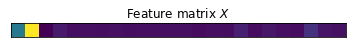

In [6]:
plt.imshow(np.expand_dims(X0,0))
plt.xticks([])
plt.yticks([])
plt.title('Feature matrix $X$');

In [7]:
X0 = X0.T

In [8]:
X0.shape

(24,)

In [9]:
linalg.matrix_rank(X0)

1

In [10]:
# UPDRS score
# Response vector u [=] n_samples x n_targets
# 1 x 4
u = np.expand_dims(np.array([0,1,24,1]).T,0)

In [11]:
# Simple 1D example
scaler = StandardScaler()
X0 = scaler.fit_transform(X0.reshape(-1,1))
X0 = X0.T

In [12]:
X0

array([[ 1.49026912,  4.45014231, -0.50399848, -0.13661301, -0.3111357 ,
        -0.31024686, -0.31957467, -0.28881898, -0.32230454, -0.30929653,
        -0.30964559, -0.30040939, -0.30194765, -0.3531381 , -0.30576107,
        -0.32485802, -0.07256483, -0.33516325, -0.19155935, -0.30844507,
        -0.33007724,  0.19509549, -0.21789885, -0.28204975]])

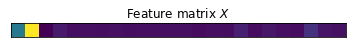

In [13]:
plt.imshow(X0)
plt.xticks([])
plt.yticks([])
plt.title('Feature matrix $X$');

In [14]:
reg = Lasso(alpha=0.00001,fit_intercept=False, max_iter=10000, tol=0.1)
w_min = reg.fit(X0,u)
# reg.predict()

c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [15]:
w_min.coef_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.71012242e-01,  2.00581372e-06, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 1.61044663e+01,  2.00581372e-06, -0.00000000e

In [16]:
#Closed form solution to L2 norm of Aw = u
L = linalg.det(np.matmul(X0,X0.T))
if abs(L) > 0:
    wc =np.matmul(X0.T,linalg.inv(np.matmul(X0,X0.T)))*np.squeeze(u)

In [17]:
(w_min.coef_).shape

(4, 24)

In [18]:
X0.shape

(1, 24)

In [19]:
# Compute u_est = Aw_min
u_est = np.matmul((X0),(w_min.coef_).T)

In [20]:
u_est

array([[ 0.        ,  0.99999775, 23.99999775,  0.99999775]])

In [21]:
mse = np.sum(np.sqrt((u-u_est)**2),1)

In [22]:
mse

array([6.74135744e-06])

In [23]:
# Compute u_est = Aw_min
u_c = np.matmul((X0),(wc))

In [24]:
u_c

array([[ 0.,  1., 24.,  1.]])